In [63]:
import pandas as pd
import numpy as np
import os

In [122]:
#os.chdir('D:/Penn/Career/Citadel/2021datathon')
match = pd.read_csv('../match_discrete_htwt_drop30.csv')
match['date']  = pd.to_datetime(match['date'])
df_clus = pd.read_csv('team_att_all_w_cluster_gmm9.csv')
df_clus['date']  = pd.to_datetime(df_clus['date'])

In [123]:
match.shape

(17581, 201)

In [124]:
Nc = df_clus['cluster'].max() + 1
Nc

9

In [125]:
def get_meta(team_id, date):
    df = df_clus[df_clus['team_id'] == team_id]

    # return -1 if there is no record of the team's meta
    if df.shape[0] == 0:
        return -1

    clus = df.iloc[0, :]['cluster']
    for i in range(1, df.shape[0]):
        if df.iloc[i, :]['date'] < date:
            clus = df.iloc[i, :]['cluster']
        else:
            break
    
    return clus

In [126]:
# The following matrices register information only on the upper half - i.e. i >= j
goal_mat = np.zeros((Nc, Nc)) # goal_mat[i][j] is the net # of goals meta i scored against meta j. Could be positive or negative
match_mat = np.zeros((Nc, Nc)) # match_mat[i][j] is the total # of matches meta i played against meta j

for row in range(match.shape[0]):
    h_meta = get_meta(match['home_team_id'].loc[row], match['date'].loc[row])
    if h_meta < 0:
        continue
    a_meta = get_meta(match['away_team_id'].loc[row], match['date'].loc[row])
    if a_meta < 0:
        continue

    if h_meta < a_meta:
        match_mat[h_meta, a_meta] += 1
        goal_mat[h_meta, a_meta] += match['home_team_goal'].loc[row] - match['away_team_goal'].loc[row]
    else:
        match_mat[a_meta, h_meta] += 1
        goal_mat[a_meta, h_meta] += match['away_team_goal'].loc[row] - match['home_team_goal'].loc[row]

In [127]:
print(match_mat)
print(goal_mat)

[[ 736.    7.  586.  138.   84.  265.   17.   24.  144.]
 [   0.  791.   34.   36.  120.  430.    0.    0.   26.]
 [   0.    0. 1100.  253. 1901.  786.  190.    0.    0.]
 [   0.    0.    0.  214.  201.  411.  309.  274.  163.]
 [   0.    0.    0.    0. 1640. 1318.  167.   30.   12.]
 [   0.    0.    0.    0.    0. 1863.  136.   55.   98.]
 [   0.    0.    0.    0.    0.    0.  861.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.  325.  190.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  793.]]
[[-292.    8. -530. -148.    8.  -43.    0.   -5.   40.]
 [   0. -148.  -48.    8.  -28. -262.    0.    0.    3.]
 [   0.    0. -462.  -10. 1471.  681.  196.    0.    0.]
 [   0.    0.    0. -100.  176.  298.  469.  223.  120.]
 [   0.    0.    0.    0. -549.  180.   38.  -13.   -6.]
 [   0.    0.    0.    0.    0. -784.   11.  -62.  -69.]
 [   0.    0.    0.    0.    0.    0. -394.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0. -175.  -10.]
 [   0.    0.    0.    0.    0

In [128]:
meta_mat = np.divide(goal_mat, match_mat, out = np.zeros_like(match_mat), where = match_mat != 0)
np.set_printoptions(precision = 3)
print(meta_mat)

[[-0.397  1.143 -0.904 -1.072  0.095 -0.162  0.    -0.208  0.278]
 [ 0.    -0.187 -1.412  0.222 -0.233 -0.609  0.     0.     0.115]
 [ 0.     0.    -0.42  -0.04   0.774  0.866  1.032  0.     0.   ]
 [ 0.     0.     0.    -0.467  0.876  0.725  1.518  0.814  0.736]
 [ 0.     0.     0.     0.    -0.335  0.137  0.228 -0.433 -0.5  ]
 [ 0.     0.     0.     0.     0.    -0.421  0.081 -1.127 -0.704]
 [ 0.     0.     0.     0.     0.     0.    -0.458  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.538 -0.053]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -0.42 ]]


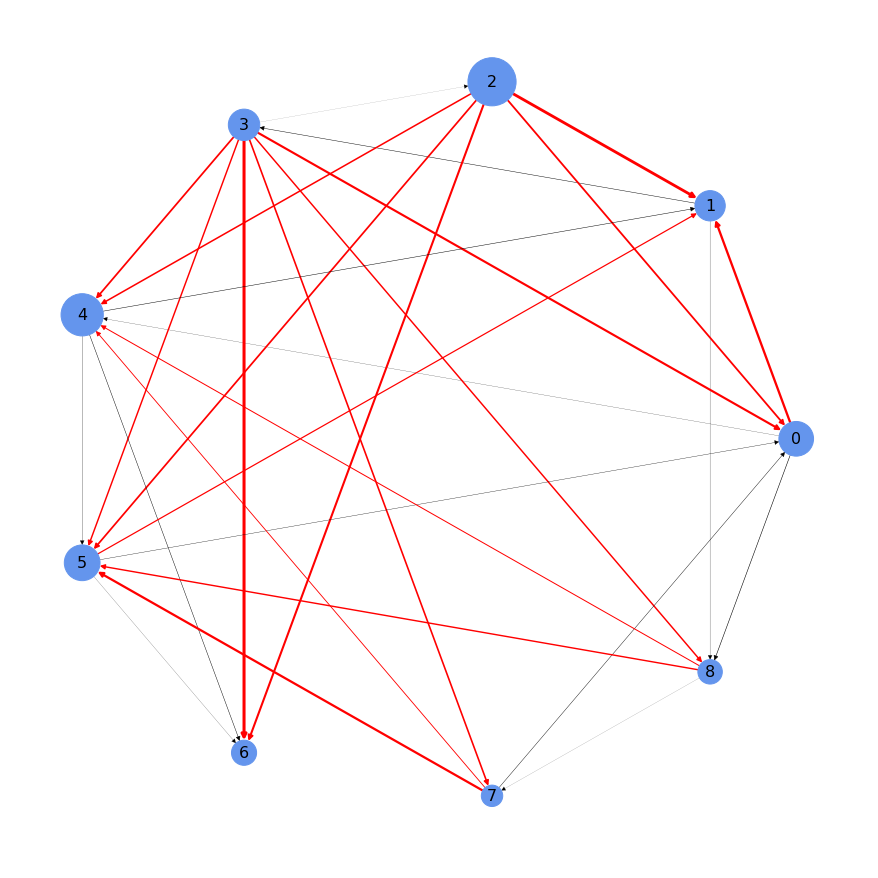

In [129]:
import networkx as nx
import matplotlib.pyplot as plt

wt_fac = 2
nd_base = 200
nd_fac = 0.5

G = nx.DiGraph()
wt_thr = np.percentile(abs(meta_mat), 75)

'''
Params to Change
'''
threshold=0
for i in range(0, Nc):
    for j in range(i, Nc):
        color = 'red' if abs(meta_mat[i, j]) > wt_thr else 'black'
        if meta_mat[i, j] > threshold:
            G.add_edge(i, j, weight = meta_mat[i, j] * wt_fac, color = color)
        elif meta_mat[i, j] < threshold:
            G.add_edge(j, i, weight = -meta_mat[i, j] * wt_fac, color = color)
        else:
            G.add_edge(j, i, weight = 0, color = "white",alpha=0.1)
pos = nx.circular_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [G[u][v]['color'] for u, v in edges]

plt.figure(figsize=(12,12)) 
nx.draw(G, pos, width = weights, with_labels = True, \
    node_size = np.array([sum(match_mat[i]) for i in range(Nc)]) * nd_fac + nd_base, \
    node_color='cornflowerblue', font_size = 16, edge_color = colors)

'''
Params to Change
'''
name="gmm9.png"
plt.savefig(name)
plt.show()


In [130]:
clus_expl=df_clus['cluster']
df_clus_expl=df_clus[[x for x in df_clus.columns if x not in ['team_id','date','next_date','Unnamed: 0','cluster']]]
df_clus_expl.head()

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlayPositioningClass_Free Form,buildUpPlayPositioningClass_Organised,...,preferred_foot_right,preferred_foot_left,attacking_work_rate_medium,attacking_work_rate_high,attacking_work_rate_low,defensive_work_rate_medium,defensive_work_rate_high,defensive_work_rate_low,height,weight
0,70,70,70,70,70,60,70,70,0,1,...,77.105263,22.894737,0.720624,0.202475,0.076901,0.793745,0.188565,0.017690,182.125832,163.418926
1,47,52,53,48,52,47,47,52,0,1,...,65.318182,32.181818,0.769388,0.105253,0.100360,0.831446,0.128958,0.014596,181.284803,164.746970
2,58,62,45,70,55,40,40,60,0,1,...,56.793388,41.388430,0.741781,0.121579,0.118457,0.844389,0.043324,0.094105,181.774645,160.814587
3,62,45,40,50,55,42,42,60,0,1,...,56.631177,43.368823,0.708245,0.165465,0.126290,0.832569,0.090964,0.076467,180.163178,158.986350
4,58,62,56,68,57,41,42,60,0,1,...,63.516746,36.483254,0.666268,0.243301,0.090431,0.736124,0.133493,0.130383,179.556124,160.926901


In [140]:
from sklearn.tree import _tree, DecisionTreeClassifier
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        # feature[i] holds the feature to split on, for the internal node i.
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
            # left child
            left_rule = current_rule + ["({} <= {})".format(name, format(threshold, ".3f"))]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
            # right child
            right_rule = current_rule + ["({} > {})".format(name, format(threshold, ".3f"))]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
            # register new rule to dictionary
            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append((rule_string, class_probability))
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

'''
Params to Change
'''
# make Decision Tree
min_samples_leaf=30
pruning_level=0.01
max_depth=6
tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level,max_depth=max_depth)
tree.fit(df_clus_expl,clus_expl)

# get decision tree rules
feature_names = df_clus_expl.columns
class_rule_dict = get_class_rules(tree, feature_names)

report_class_list = []
for class_name in class_rule_dict.keys():
    rule_list = class_rule_dict[class_name]
    combined_string = ""
    for rule in rule_list:
        combined_string += "Proportion:[{}]\n {}\n\n".format(format(rule[1], ".3f"), rule[0])
    report_class_list.append((class_name, combined_string))

cluster_instance_df = pd.Series(clus_expl).value_counts().reset_index()
cluster_instance_df.columns = ['class_name', 'instance_count']
report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])

,class_name,instance_count,rule_list
3,0,76,Proportion:[0.786] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions > 52.861) and (buildUpPlayDribbling <= 40.750) and (strength > 71.168)
7,1,57,Proportion:[0.915] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions <= 52.861) and (long_shots <= 48.668) and (positioning <= 47.825)
2,2,154,Proportion:[0.463] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions > 73.828) and (positioning <= 59.544)Proportion:[0.875] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions > 73.828) and (positioning > 59.544)
5,3,65,Proportion:[1.000] (buildUpPlayPositioningClass_Free Form > 0.500)
1,4,184,Proportion:[0.491] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions <= 52.861) and (long_shots > 48.668) and (weight <= 167.637)Proportion:[0.557] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions > 52.861) and (buildUpPlayDribbling > 40.750) and (curve <= 57.315)
0,5,222,Proportion:[0.531] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions <= 52.861) and (long_shots <= 48.668) and (positioning > 47.825)Proportion:[0.849] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions <= 52.861) and (long_shots > 48.668) and (weight > 167.637)Proportion:[0.500] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions > 52.861) and (buildUpPlayDribbling <= 40.750) and (strength <= 71.168)
6,6,60,Proportion:[0.493] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking <= 23.252) and (reactions <= 73.828) and (interceptions > 52.861) and (buildUpPlayDribbling > 40.750) and (curve > 57.315)
8,7,43,Proportion:[0.897] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking > 23.252) and (defenceAggression <= 42.500)
4,8,70,Proportion:[0.400] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking > 23.252) and (defenceAggression > 42.500) and (defencePressure <= 47.500)Proportion:[0.982] (buildUpPlayPositioningClass_Free Form <= 0.500) and (gk_kicking > 23.252) and (defenceAggression > 42.500) and (defencePressure > 47.500)


In [136]:
'''
Params to Change
'''
report_df.to_csv("expl_gmm9.csv")